In [17]:
from nn.models import C6_4l_clf, swish_activation
from nn import datasets
from hstar import process, trilinear
from hzz import zcandidate, angles

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

In [12]:
sample = process.Sample(weight='wt', 
    amplitude = process.Basis.SBI, components = {
    process.Basis.SBI: 'msq_sbi_sm',
    process.Basis.SIG: 'msq_sig_sm',
    process.Basis.BKG: 'msq_bkg_sm',
    process.Basis.INT: 'msq_int_sm'
  })

sample.open(csv = [
  '../ggZZ4e_all_new.csv',
  '../ggZZ4m_all_new.csv',
  '../ggZZ2e2m_all_new.csv'
  ], xs=[1.4783394, 0.47412769, 0.47412769], lumi=3000., k=1.83, nrows=1200000
)

sample.events = sample.events.sample(frac=1).reset_index(drop=True).iloc[3000000:]

print(sample.events.shape)

zmasses = zcandidate.ZmassPairChooser(sample)
leptons = zmasses.find_Z()

print(sample.events.shape)

kin_variables, filter_indices = angles.calculate(leptons.T[0], leptons.T[1], leptons.T[2], leptons.T[3])

kin_variables = kin_variables[filter_indices]
sample.events = sample.events.take(indices=filter_indices)

print(sample.events.shape)

c6_values = [10]

c6_mod = trilinear.Modifier(c6_values = [-5,-1,0,1,5], c6_amplitudes = ['msq_sbi_c6_6', 'msq_sbi_c6_10', 'msq_sbi_c6_11', 'msq_sbi_c6_12', 'msq_sbi_c6_16'])
c6_weights = c6_mod.modify(sample=sample, c6=c6_values)

test_data = datasets.build_dataset_tf(x_arr = kin_variables,
                                      param_values = c6_values,
                                      signal_weights = c6_weights,
                                      background_weights = tf.convert_to_tensor(sample.events['wt']), 
                                      normalization = 1)

0          6.917264e-12
1          4.352699e-10
2          1.308438e-09
3          1.289731e-09
4          1.347206e-13
               ...     
1199995    4.149453e-09
1199996    3.268040e-09
1199997    5.843582e-09
1199998    3.206703e-10
1199999    7.858440e-10
Name: msq_sbi_sm, Length: 3600000, dtype: float64
0          7.188681e-14
1          3.480814e-11
2          1.946946e-11
3          1.735510e-11
4          6.937648e-15
               ...     
1199995    2.349468e-11
1199996    1.260399e-10
1199997    3.164702e-10
1199998    9.147576e-13
1199999    8.251521e-11
Name: msq_sig_sm, Length: 3600000, dtype: float64
0          7.326896e-12
1          4.924589e-10
2          1.370247e-09
3          1.360140e-09
4          1.353118e-13
               ...     
1199995    4.199106e-09
1199996    3.261307e-09
1199997    6.262901e-09
1199998    3.239311e-10
1199999    8.975898e-10
Name: msq_bkg_sm, Length: 3600000, dtype: float64
0         -4.813898e-13
1         -9.161464e-11
2         

/raven/u/griesemx/git/higgs-offshell-interpretation/hzz/angles.py:59: RuntimeWarning: invalid value encountered in divide
  phi = z1.dot(n12.cross(n34))/np.abs(z1.dot(n12.cross(n34)))*np.arccos(-n12.dot(n34))
/raven/u/griesemx/git/higgs-offshell-interpretation/hzz/angles.py:59: RuntimeWarning: invalid value encountered in arccos
  phi = z1.dot(n12.cross(n34))/np.abs(z1.dot(n12.cross(n34)))*np.arccos(-n12.dot(n34))


(534352, 97)


In [13]:
print(test_data, test_data.shape)

tf.Tensor(
[[-9.9956179e-01  9.9999332e-01  9.9923694e-01 ...  2.7778470e+02
   1.0000000e+00  2.4997868e-07]
 [-7.9854858e-01  9.4311118e-01 -5.4875726e-01 ...  1.9444522e+02
   1.0000000e+00  6.1149780e-07]
 [-8.9401394e-01  8.1174827e-01  9.8946059e-01 ...  2.0158017e+02
   1.0000000e+00  1.0921680e-06]
 ...
 [-9.9960232e-01  9.9997342e-01  9.9958098e-01 ...  3.0570923e+02
   0.0000000e+00  5.6284412e-06]
 [ 9.8543578e-01  9.1428941e-01 -9.6524501e-01 ...  2.8602902e+02
   0.0000000e+00  7.3976656e-07]
 [ 8.8950205e-01  9.6081769e-01  9.7211587e-01 ...  2.8810672e+02
   0.0000000e+00  2.0617863e-06]], shape=(1068704, 10), dtype=float32) (1068704, 10)


In [14]:
model = keras.models.load_model('outputs_single/ckpt/checkpoint.model_1.keras', custom_objects={'C6_4l_clf_reduced_nonprm': C6_4l_clf, 'swish_activation': swish_activation})

/raven/u/griesemx/git/bsc-thesis/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
predictions = []
real_ratios = []

arr_len = test_data.shape[0]/len(c6_values)

for i in range(len(c6_values)):
    c6 = c6_values[i]
    data = test_data[int(i*arr_len):int((i+0.5)*arr_len),:8]
    pred = model.predict(data)
    predictions.append(pred)

    real_ratio = test_data[int(i*arr_len):int((i+0.5)*arr_len),9]/test_data[int((i+0.5)*arr_len):int((i+1)*arr_len),9]
    real_ratios.append(real_ratio)

predictions = tf.convert_to_tensor(predictions)

ratios = tf.squeeze(predictions/(1-predictions), axis=2)

print(ratios)

real_ratios = tf.convert_to_tensor(real_ratios)

print(real_ratios)

I0000 00:00:1731407791.155112  133891 service.cc:148] XLA service 0x148c9c2c8230 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731407791.164072  133891 service.cc:156]   StreamExecutor device (0): Host, Default Version
2024-11-12 11:36:33.340890: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1731407797.570461  133891 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


16699/16699 ━━━━━━━━━━━━━━━━━━━━ 45s 2ms/step
tf.Tensor([[0.99969894 0.9996987  0.99969894 ... 0.99969894 0.99969894 0.99969894]], shape=(1, 534352), dtype=float32)
tf.Tensor([[1.0195899  0.99777037 0.99966973 ... 1.0151569  1.0100434  1.0044048 ]], shape=(1, 534352), dtype=float32)


Text(0, 0.5, 'NN estimated ratio')

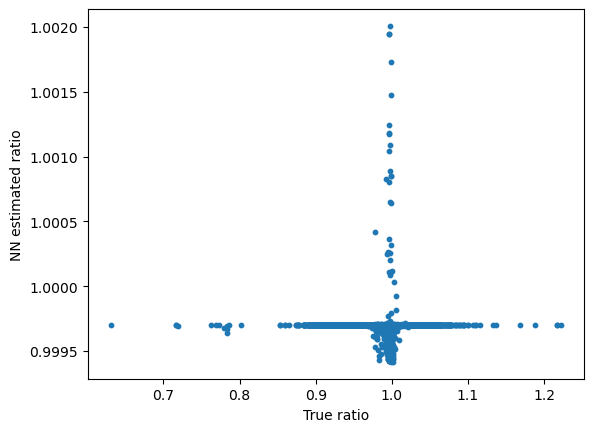

In [21]:
real = real_ratios.numpy()
pred = ratios.numpy()

plt.scatter(real, pred, s=10)
plt.xlabel('True ratio')
plt.ylabel('NN estimated ratio')